In [171]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchtext.transforms as T
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.schemas import NlpContext
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.text import build_vocab
from torchlake.sequence_data.models.lstm import LSTMDiscriminator
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import CoNLL2000Chunking

# setting


In [172]:
artifacts_path = Path("../../artifacts/bilstm")
data_path = Path("../../data/CoNLL2000")

In [173]:
batch_size = 128
context = NlpContext()

# data


In [174]:
def datapipe_factory(datapipe, text_transform=None, label_transform=None):
    datapipe = datapipe.map(
        lambda pair: [[word.lower() for word in pair[0]], pair[1]]
    ).filter(lambda item: len(item[0]) > context.min_seq_len)

    if text_transform:
        datapipe = datapipe.map(lambda item: (text_transform(item[0]), item[1]))

    if label_transform:
        datapipe = datapipe.map(lambda item: (item[0], label_transform(item[1])))

    return datapipe

In [175]:
train_data, test_data = CoNLL2000Chunking(data_path.as_posix())

In [176]:
vocab = build_vocab(map(lambda it: it[0], train_data))
label_vocab = build_vocab(map(lambda it: it[1], train_data))

In [177]:
VOCAB_SIZE = len(vocab)
NUM_CLASS = len(label_vocab)

In [178]:
VOCAB_SIZE, NUM_CLASS

(4406, 48)

In [179]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(context.max_seq_len - 2),
    T.AddToken(token=context.bos_idx, begin=True),
    T.AddToken(token=context.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(context.max_seq_len, context.padding_idx),
)

In [180]:
label_transform = T.Sequential(
    T.VocabTransform(label_vocab),
    T.Truncate(context.max_seq_len - 2),
    T.AddToken(token=context.bos_idx, begin=True),
    T.AddToken(token=context.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(context.max_seq_len, context.padding_idx),
)

In [181]:
def collate_fn(batch: list):
    text_placeholder, label_placeholder = [], []

    for row in batch:
        text, label = row[0], row[1]
        text_placeholder.append(text)
        label_placeholder.append(label)

    return torch.stack(text_placeholder), torch.stack(label_placeholder)

In [182]:
NUM_WORKERS = get_num_workers()

In [183]:
train_iter = DataLoader(
    datapipe_factory(train_data, text_transform, label_transform),
    batch_size=batch_size,
    # collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    shuffle=True,
    drop_last=True,
)

test_iter = DataLoader(
    datapipe_factory(test_data, text_transform, label_transform),
    batch_size=batch_size,
    # collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [184]:
for text, label in train_iter:
    print(text.shape, label.shape)
    break

torch.Size([128, 256]) torch.Size([128, 256])


# model


In [185]:
DEVICE = torch.device(context.device)

In [186]:
EMBED_DIM = 300
HIDDEN_DIM = 256
model = LSTMDiscriminator(
    VOCAB_SIZE,
    EMBED_DIM,
    HIDDEN_DIM,
    NUM_CLASS,
    num_layers=1,
    bidirectional=True,
    context=context,
    sequence_output=True,
).to(DEVICE)

In [187]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
LSTMDiscriminator                        --
├─Embedding: 1-1                         1,321,800
├─LSTM: 1-2                              1,142,784
├─LayerNorm: 1-3                         1,024
├─Linear: 1-4                            24,624
Total params: 2,490,232
Trainable params: 2,490,232
Non-trainable params: 0

# train


In [188]:
EPOCHS = 30

In [189]:
trainer = ClassificationTrainer(EPOCHS, DEVICE, feature_last=True)

In [190]:
criterion = nn.CrossEntropyLoss(ignore_index=context.padding_idx, label_smoothing=0)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-4)

In [191]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [192]:
training_loss = trainer.run(train_iter, model, optimizer, criterion, scheduler)

67it [00:05, 12.20it/s]


epoch 1 : 0.01941645484584481


67it [00:04, 13.68it/s]


epoch 2 : 0.013692945575536186


67it [00:05, 12.45it/s]


epoch 3 : 0.011740108632218482


67it [00:05, 12.94it/s]


epoch 4 : 0.01058186152810926


67it [00:05, 11.91it/s]


epoch 5 : 0.009785068930307431


67it [00:05, 13.20it/s]


epoch 6 : 0.009176272356799289


67it [00:05, 13.35it/s]


epoch 7 : 0.008698735775342628


67it [00:04, 13.59it/s]


epoch 8 : 0.008305386098018333


67it [00:05, 13.14it/s]


epoch 9 : 0.007976411681955875


67it [00:04, 13.53it/s]


epoch 10 : 0.007701459180897296


67it [00:04, 13.58it/s]


epoch 11 : 0.007447840812713352


67it [00:05, 13.01it/s]


epoch 12 : 0.007237974443097613


67it [00:05, 12.37it/s]


epoch 13 : 0.007043014662757294


67it [00:05, 13.34it/s]


epoch 14 : 0.0068662159575788835


67it [00:05, 12.93it/s]


epoch 15 : 0.006709185199561848


67it [00:04, 13.43it/s]


epoch 16 : 0.006559998234872942


67it [00:05, 13.09it/s]


epoch 17 : 0.006425243183803647


67it [00:05, 12.61it/s]


epoch 18 : 0.006304182918436492


67it [00:04, 13.87it/s]


epoch 19 : 0.006196714889035741


67it [00:04, 14.16it/s]


epoch 20 : 0.006078159394882508


67it [00:04, 14.24it/s]


epoch 21 : 0.005972602564507901


67it [00:04, 14.81it/s]


epoch 22 : 0.00587892939628505


67it [00:04, 14.73it/s]


epoch 23 : 0.005786348134279251


67it [00:04, 14.52it/s]


epoch 24 : 0.005705128340467588


67it [00:05, 12.67it/s]


epoch 25 : 0.005623415494754688


67it [00:05, 13.34it/s]


epoch 26 : 0.005576681206697848


67it [00:04, 13.77it/s]


epoch 27 : 0.005561167096246535


67it [00:05, 13.07it/s]


epoch 28 : 0.005561161550012098


67it [00:05, 13.08it/s]


epoch 29 : 0.005549148642527524


67it [00:05, 12.88it/s]

epoch 30 : 0.00554326754897388


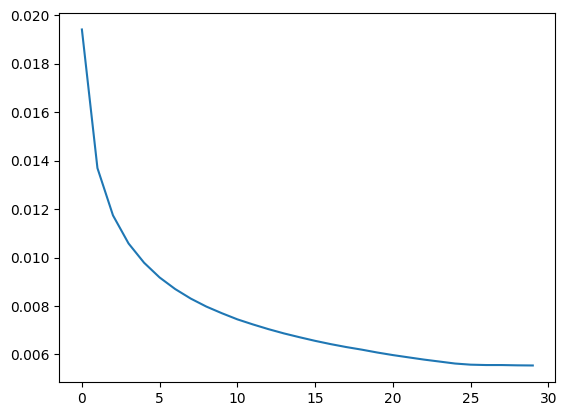

In [193]:
plt.plot(training_loss)

# inference


In [194]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE, feature_dim=-1)

In [195]:
confusion_matrix = evaluator.run(test_iter, model)

0it [00:00, ?it/s]d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\iter\combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
16it [00:01, 13.68it/s]

[[   0    0    0 ...    0    0    0]
 [   0 1949    0 ...    0    0    0]
 [   0    0 1949 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]


In [196]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(label_vocab.get_itos(), per_class_acc)

<unk>     : 0.0
<bos>     : 1.0
<eos>     : 1.0
<pad>     : 0.0
NN        : 0.5551181102362205
IN        : 0.9212640599892876
NNP       : 0.6421643695763144
DT        : 0.9556818181818182
NNS       : 0.43619909502262444
JJ        : 0.3976169461606355
,         : 1.0
.         : 0.9922440537745605
CD        : 0.5714285714285714
VBD       : 0.5823488533703961
RB        : 0.4938811188811189
VB        : 0.6924564796905223
CC        : 0.9845814977973568
TO        : 1.0
VBN       : 0.39082751744765704
VBZ       : 0.5995055624227441
PRP       : 0.8205521472392638
VBG       : 0.1910919540229885
VBP       : 0.565922920892495
MD        : 0.8933649289099526
PRP$      : 0.9350282485875706
POS       : 0.9664082687338501
$         : 0.9885496183206107
``        : 0.9833887043189369
''        : 0.9831081081081081
:         : 0.8987341772151899
WDT       : 0.5773195876288659
JJR       : 0.5549738219895288
WP        : 0.9519230769230769
WRB       : 0.9111111111111111
NNPS      : 0.0
JJS       : 0.06493

d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\common\controller\evaluator.py:104: RuntimeWarning: invalid value encountered in divide
  return np.where(total == 0, 0, hits / total)


In [197]:
per_class_acc.mean()

0.5593472618422218

d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\common\controller\evaluator.py:123: RuntimeWarning: invalid value encountered in divide
  percentage = np.where(total == 0, 0, hits / total)


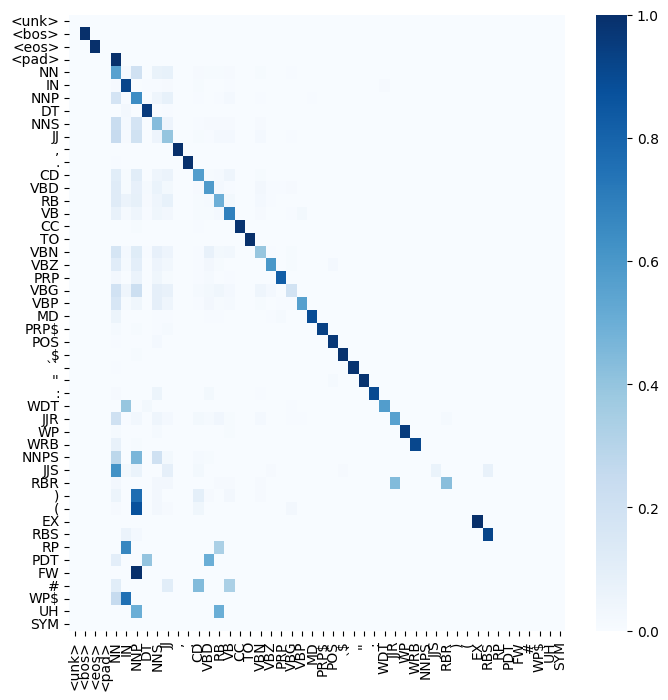

In [198]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    label_vocab.get_itos(),
    "Blues",
    annot=False,
    figsize=(8, 8),
)

In [199]:
model_path = artifacts_path / 'bilstm.pth'

In [200]:
torch.save(model.state_dict(), model_path.as_posix())

In [201]:
get_file_size(model_path)

'9.5MiB'

In [202]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>